In [0]:
! pip install torch

    100% |████████████████████████████████| 591.8MB 28kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x60a00000 @  0x7f8b85f1a2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


Nous nous intéressons maintenant à un problème de transduction d'une séquence de symbole en une autre (autrement dit de la traduction). Traduire de séquences de mots d'une langue à une autre n'est pas raisonnable sans GPU. Nous allons donc nous intéresser au problème de la phonétisation automatique. Étant donné une séquence de graphèmes, nous devons générer la séquence de phonèmes correspondant.

Ce problème peut être vu comme la composition de deux problèmes vus dans les notebooks précédents :
- le problème de prédiction de la polarité d'un tweet : lire une séquence en entrée et produire une représentation à partir de cette séquence (ici les graphèmes)
- le problème de modèlisation du langage : partir d'une représentation cachée puis générer une séquence de symboles (ici les phonèmes)

On appelle souvent ce cadre "encodeur-décodeur" ou "seq2seq2.

Comme les modèles de langages conditionnés (par leur état caché initial) ne fonctionnent pas très car ils doivent emagasiner toute l'information sur la séquence vue en entrée dans une représentation de taille fixe, nous dans une deuxième étape augmenter le modèle d'un macanisme d'attention.

Commençons par télécharger un dictionnaire phonétisé de petite taille créé à partir d'un sous-ensemble du dictionnaire de CMU (utilisé dans l'ASR sphinx). Ce dictionnaire, regénérable avec les commandes en commentaire, contient sur chaque ligne un mot, suivi d'un séparateur "|||" suivi d'une sèquence de phonèmes.

In [0]:
%matplotlib inline

In [0]:

! wget -q http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b
! iconv -f latin1 cmudict-0.7b | grep "^[A-Z]" | awk '{ if( NF < 16 ){print} }' | sed 's/([0-9]*)//;s/  / ||| /' | shuf | head -5500 > cmudict-0.7b.filtered
! [ -f cmudict-0.7b.filtered ] || wget -q http://pageperso.lif.univ-mrs.fr/~benoit.favre/files/cmudict-0.7b.filtered
! head cmudict-0.7b.filtered

FREEFALL ||| F R IY1 F AO2 L
ANTHROPOLOGIST ||| AE2 N TH R AH0 P AA1 L AH0 JH IH0 S T
VESEY ||| V EH1 S IY0
SUSTAITA ||| S UW0 S T EY1 T AH0
SIXTEEN ||| S IH1 K S T IY1 N
HAMS ||| HH AE1 M Z
REDDISH ||| R EH1 D IH0 SH
RODRIGO ||| R AH0 D R IY1 G OW0
TRUNK ||| T R AH1 NG K
FRANCESE ||| F R AA0 N CH EY1 Z IY0


Le chargement des données nécessite de convertir les mots en listes de caractères, et la séquence de phonème en liste de chaînes de caractères.

In [0]:
words = []
phonemes = []

with open("cmudict-0.7b.filtered") as fp:
    for line in fp:
        word, phones = line.strip().split(' ||| ')
        words.append(list(word))
        phonemes.append(phones.split())

print(words[42], phonemes[42])
len(words)

['R', 'E', 'S', 'E', 'A', 'R', 'C', 'H'] ['R', 'IY0', 'S', 'ER1', 'CH']


5500

Si on regarde la distribution des tailles de mots et de phonétisations, on peut voir que l'on couvre la plupart des cas avec une longueur maximale de 16.

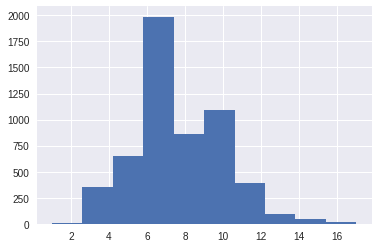

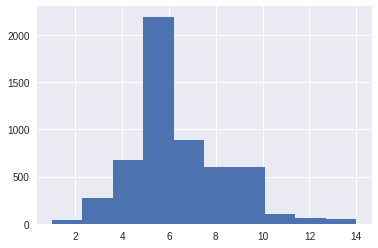

In [0]:
from matplotlib import pyplot as plt

plt.hist([len(x) for x in words])
plt.show()
plt.hist([len(x) for x in phonemes])
plt.show()

La conversion des entrées et sorties du système en séquences d'entiers se fait comme pour l'analyse de sentiment et le modèle de langage. Notez la présence du symbole `<start>` pour la partie modèle de langage.

In [0]:
import collections

letter_vocab = collections.defaultdict(lambda: len(letter_vocab))
letter_vocab['<eos>'] = 0

phoneme_vocab = collections.defaultdict(lambda: len(phoneme_vocab))
phoneme_vocab['<eos>'] = 0
phoneme_vocab['<start>'] = 1

int_words = []
int_phonemes = []

for word, phones in zip(words, phonemes):
    int_words.append([letter_vocab[x] for x in word])
    int_phonemes.append([phoneme_vocab[x] for x in phones])

print(len(letter_vocab), len(phoneme_vocab))
print(int_words[42], int_phonemes[42])

rev_letter_vocab = {y: x for x, y in letter_vocab.items()}
rev_phoneme_vocab = {y: x for x, y in phoneme_vocab.items()}

print([rev_letter_vocab[x] for x in int_words[42]], [rev_phoneme_vocab[x] for x in int_phonemes[42]])

33 71
[2, 3, 13, 3, 4, 2, 21, 8] [3, 19, 15, 53, 35]
['R', 'E', 'S', 'E', 'A', 'R', 'C', 'H'] ['R', 'IY0', 'S', 'ER1', 'CH']


Nous allons utiliser des hyperparamètres de magnitude réduite pour pouvoir entraîner le système sur CPU. Sur GPU, on pourrait prendre de bien plus grands états cachés. De plus, rien ne nous empêche d'avoir des tailles d'embedding et d'état caché différentes selon que l'on est dans la partie "encodeur" ou "décodeur".

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

max_len = 16
batch_size = 16
embed_size = 8
hidden_size = 32

Une fois que l'on a des listes de listes d'entiers, il est relativement simple de les mettre dans des tenseurs avec le padding habituel. Le chois de coller les séquences à gauche est complètement arbitraire.

In [0]:
X = torch.zeros((len(int_words), max_len)).long()
Y = torch.zeros((len(int_phonemes), max_len)).long()

for i, (word, phones) in enumerate(zip(int_words, int_phonemes)):
    word_length = min(max_len, len(word))
    X[i,0:word_length] = torch.LongTensor(word[:word_length])
    phones_length = min(max_len, len(phones))
    Y[i,0:phones_length] = torch.LongTensor(phones[:phones_length])

print(X[42].tolist())
print(Y[42].tolist())

[2, 3, 13, 3, 4, 2, 21, 8, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 19, 15, 53, 35, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Le corpus est divisé en un ensemble d'entraînement et de validation, et nous utilisons les facilités proposées par pytorch pour la génération des batches.

In [0]:
X_train = X[:5000]
Y_train = Y[:5000]
X_valid = X[5000:]
Y_valid = Y[5000:]

from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
valid_set = TensorDataset(X_valid, Y_valid)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

Voici notre premier modèle. C'est un encodeur-decodeur classique qui utilise une couche d'embedding pour projeter les caractères du mot vers un espace d'embedding, puis une couche recurrente bidirectionnelle pour créer une représentation de l'intégralité du mot. La représentation issue de cette couche sera de taille `(num_layers * num_directions, batch_size, hidden_size)`, donc il faut que la seconde couche recurrente qui va générer les phonèmes ait une couche cachée de taille `2 * hidden_size`. Cette dernière est construite comme un modèle de langage : elle commence par le symbole `<start>`, le projette dans un espace d'embedding, le passe dans la couche recurrent, puis la sortie de cette dernière dans une couche de décision qui génère un vecteur de scores de la taille du vocabulaire des phonèmes.

L'inférence est divisée en deux, la partie encodage qui renvoie l'état caché à l'issue de la lecture du mot, et la partie décodage qui renvoie la décision à chaque position pour la séquence de phonème ainsi que l'état caché à la fin (pour pouvoir faire un décodage phonème par phonème comme on l'a fait dans le modèle de langage).

In [0]:
class Seq2SeqModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.letter_embed = nn.Embedding(len(letter_vocab), embed_size, padding_idx=letter_vocab['<eos>'])
        self.phoneme_embed = nn.Embedding(len(phoneme_vocab), embed_size)
        self.letter_rnn = nn.GRU(embed_size, hidden_size, num_layers=1, dropout=0.3, bias=False, bidirectional=True, batch_first=True)
        self.phoneme_rnn = nn.GRU(embed_size, 2 * hidden_size, num_layers=1, dropout=0.3, batch_first=True)
        # size of hidden state: (num_layers * num_directions, batch_size, hidden_size)
        self.decision = nn.Linear(hidden_size * 2 * 1, len(phoneme_vocab))
    
    def encode(self, word):
        embed = self.letter_embed(word)
        output, h_n = self.letter_rnn(embed)
        return h_n.transpose(0, 1).contiguous().view(1, word.size(0), -1)
    
    def decode(self, phones, h_0):
        embed = self.phoneme_embed(phones)
        output, h_n = self.phoneme_rnn(embed, h_0)
        return self.decision(output), h_n
    
    def forward(self, word, phones):
        output, h_n = self.decode(phones, self.encode(word))
        return output

seq2seq_model = Seq2SeqModel()
seq2seq_model

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Seq2SeqModel(
  (letter_embed): Embedding(33, 8, padding_idx=0)
  (phoneme_embed): Embedding(71, 8)
  (letter_rnn): GRU(8, 32, bias=False, batch_first=True, dropout=0.3, bidirectional=True)
  (phoneme_rnn): GRU(8, 64, batch_first=True, dropout=0.3)
  (decision): Linear(in_features=64, out_features=71, bias=True)
)

On peut vérifier que le modèle renvoie bien un tenseur de taille `(batch_size, sequence_length, num_phonemes)`. Pour celà nous passons $Y$ mais ce dernier représente les phonèmes à générer, pas les phonèmes précédents.

In [0]:
seq2seq_model(Variable(X[:3]), Variable(Y[:3])).size()

torch.Size([3, 16, 71])

L'évaluation sur les données de validation peut renvoyer la perplexité (ou un taux d'erreur). Par contre, le `loader` renvoie des paires $(x, y)$ contenant des batches de mots et phonétisations correspondantes. Donc il est nécessaire de créer une nouvelle variable qui contient les phonèmes décalés vers la gauche (phonème précédent) précédés du symbole `<start>`. Pour conserver la taille de séquence, on utilise le sous-tenseur `y[:,:-1]` qui représente tous les éléments de y sauf le dernier (sur la dimension 1), pour le batch en intégralité (dimension 0). 

In [0]:
import math

def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = num = 0
    for x, y in loader:
        x2 = torch.cat([phoneme_vocab['<start>'] * torch.ones(y.size(0), 1).long(), y[:,:-1]], 1)
        y_scores = model(Variable(x, volatile=True), Variable(x2, volatile=True))
        loss = criterion(y_scores.view(y.size(0) * y.size(1), -1), Variable(y.view(y.size(0) * y.size(1)), volatile=True))
        total_loss += loss.data
        num += len(y)
    return total_loss / num, math.exp(total_loss / num)

perf(seq2seq_model, valid_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


(tensor(0.2729), 1.3137913554511398)

Il est alors nécessaire de modifier la fonction d'apprentissage du modèle de langage de la même manière.

In [0]:
def fit(model, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            x2 = torch.cat([phoneme_vocab['<start>'] * torch.ones(y.size(0), 1).long(), y[:,:-1]], 1)
            optimizer.zero_grad()
            y_scores = model(Variable(x), Variable(x2))
            loss = criterion(y_scores.view(y.size(0) * y.size(1), -1), Variable(y.view(y.size(0) * y.size(1))))
            loss.backward()
            optimizer.step()
            total_loss += loss.data
            num += len(y)
        print(epoch, total_loss / num, *perf(model, valid_loader))

fit(seq2seq_model, 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


0 tensor(0.1127) tensor(0.0954) 1.1001021159340694
1 tensor(0.0854) tensor(0.0844) 1.088081532941681
2 tensor(0.0763) tensor(0.0764) 1.0794290972281513
3 tensor(0.0685) tensor(0.0703) 1.07285892354117
4 tensor(0.0627) tensor(0.0647) 1.0668533037404455
5 tensor(0.0584) tensor(0.0607) 1.0626084580406356
6 tensor(0.0547) tensor(0.0576) 1.0592486585474814
7 tensor(0.0517) tensor(0.0551) 1.0566601707738004
8 tensor(0.0491) tensor(0.0530) 1.0544112063233242
9 tensor(0.0468) tensor(0.0512) 1.0525525552967971


Nous pouvons faire une fonction de génération pour ce modèle. La différence avec le modèle de langage est que nous commençon avec un état caché généré par l'encodeur, et que la fonction `decode()` permet de générer la séquence phonème par phonème.

Une fois le modèle entraîné, on s'apperçoit que le génèrateur n'est pas si bon. En général, il commence bien les phonétisations mais n'arrive pas à les terminer. Il ajoute souvent des sons qui n'apparaissent pas. Ce phénomène est dû à deux problèmes :
- l'état caché qui sert à encoder le mot entier est limité et partagé avec celui utilisé pour le décodage (on pourrait concaténer les embeddings des phonèmes passés en entrée avec une copie de cet état caché à chaque étape, pour ne pas perdre la mémoire). Entraîner le modèle plus longtemps avec plus de données et un plus grand état caché pourrait améliorer la situtation.
- il y a une différence entre les conditions d'apprentissage et de prédiction car en apprentissage on utilise le symbole précédent de référence (méthode "teacher forcing") alors qu'en test, on utilise le symbole prédit, potentiellement faux. Des méthodes ont été proposées pour passer de la distribution forcée à la distribution réelle au court de l'apprentissage, mais c'est compliqué à mettre en oeuvre.

Heureusement, il y a les mécanismes d'attention.

In [0]:
def generate_seq2seq(model, word):
    int_word = [letter_vocab[letter] for letter in word]
    x = Variable(torch.LongTensor(int_word).view(1, -1))
    hidden = model.encode(x)
    
    x2 = Variable(torch.zeros((1, 1)).long(), volatile=True)
    x2[0, 0] = phoneme_vocab['<start>']
    for i in range(200):
        y_scores, hidden = model.decode(x2, hidden)
        y_pred = torch.max(y_scores, 2)[1]
        selected = int(y_pred.data[0, 0].numpy())
        if selected == phoneme_vocab['<eos>']:
            break
        print(rev_phoneme_vocab[selected], end=' ')
        x2[0, 0] = selected
    print()

print("rev_phoneme_vocab",rev_phoneme_vocab)
generate_seq2seq(seq2seq_model, 'TALL')

rev_phoneme_vocab {0: '<eos>', 1: '<start>', 2: 'F', 3: 'R', 4: 'IY1', 5: 'AO2', 6: 'L', 7: 'AE2', 8: 'N', 9: 'TH', 10: 'AH0', 11: 'P', 12: 'AA1', 13: 'JH', 14: 'IH0', 15: 'S', 16: 'T', 17: 'V', 18: 'EH1', 19: 'IY0', 20: 'UW0', 21: 'EY1', 22: 'IH1', 23: 'K', 24: 'HH', 25: 'AE1', 26: 'M', 27: 'Z', 28: 'D', 29: 'SH', 30: 'G', 31: 'OW0', 32: 'AH1', 33: 'NG', 34: 'AA0', 35: 'CH', 36: 'W', 37: 'EY2', 38: 'EH2', 39: 'ER0', 40: 'AO1', 41: 'AW2', 42: 'AY2', 43: 'B', 44: 'AY1', 45: 'AA2', 46: 'OW1', 47: 'EY0', 48: 'Y', 49: 'UW1', 50: 'AW1', 51: 'UH1', 52: 'UW2', 53: 'ER1', 54: 'AO0', 55: 'IY2', 56: 'OY2', 57: 'AE0', 58: 'EH0', 59: 'ZH', 60: 'AH2', 61: 'AW0', 62: 'OW2', 63: 'OY1', 64: 'IH2', 65: 'UH2', 66: 'AY0', 67: 'ER2', 68: 'DH', 69: 'OY0', 70: 'UH0'}
T EH1 L AH0 N T 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


Les mechanismes d'attention reprennent l'idée provenant de la cognition humaine que nous pouvons porter notre attention sur un sous-ensemble des entrées plutôt que devoir en appréhender l'integralité en permanence. Pour un problème `seq2seq`, ceci va se traduire en l'utilisation sélective des états cachés des caractères du mot en entrée en fonction du phonème que l'on est en train de générer, plutôt que de prendre le dernier état caché de la séquence.

L'encodeur va cette fois renvoyer les sorties du RNN (son état caché à chaque indice) plutôt que le dernier état caché. Le décodeur les sorties du RNN sur les phonèmes, puis transforme ces sorties avec une couche linéaire appelée `attn`. On réalise la multiplication de matrice entre cette sortie transformée et chacun des état cachés sur l'entrée (les caractères du mot) et l'on prend le softmax du résultat (ce type d'attention est appelé attention multiplicative). Ceci donne une distribution sur les entrée que l'on appelle poids d'attention. On peut alors calculer la somme pondérée des états cachés en entrée par ces poids d'attention pour obtenir une représentation de l'entrée contextuelle pour le décodage du phonème courant. C'est la concaténation de cette représentation contextuelle et de la sortie du RNN sur les phonèmes qui est utilisée pour prendre la décision finale.

Les choses se compliquent un peu car nous faisons des traitements par batch, et donc les séquences de caractères contiennent du padding. Même si l'on applique la technique vue précédemment pour que l'état caché correspondant aux symboles de padding soit nul, le mechanisme d'attention risque d'utiliser les sorties du RNN à cet endroit pour apprendre des régularités sur la distribution a priori ou la longueur des entrées. Il faut donc s'assurer que le softmax donnera un poids de zéro aux états cachés issus du padding. On utilise un masque calculé sur les entrées par l'encodeur qui est vrai pour chaque symbole de padding, faux sinon. La fonction `masked_fill_()` permet alors de fixer les poids d'attention à $-\infty$ avant de faire le softmax. Comme le numérateur de ce dernier prend l'exponencielle de ses entrées, on a bien un poids à zéro. Ceci permet aussi de couper la propagation du gradient pour ces composantes. 

Pour ce qui est de la taille des différentes couches, le RNN sur les caractères est bidirectionnel donc sa sortie est 2 fois la taille de la couche cachée. La couche de transformation s'occupe de projeter l'état caché du RNN sur les phonèmes qui est unidirectionnel (donc elle passe de `hidden_size` à `2 * hidden_size`). La multiplication de matrice traite des matrices de la taille `(batch_size, sequence_length, 2 * hidden_size)` et `(batch_size, 2 * hidden_size, sequence_length)` après transposition. Il en resulte donc une matrice de poids de taille `(batch_size, sequence_length, sequence_length)`. Comme nous avons la même taille de séquences pour les mots et les phonétisations, ce n'est pas facile à interpréter, mais celà correspond en fait à `(batch_size, phoneme_size, word_size)`, donc c'est bien sur la dimensions correspondant aux mots que l'on veut faire le softmax. Finalement, le contexte créé est la somme pondérée des états cachés sur les entrées, de taille `2 * hidden_size`, et l'état caché du RNN sur les phonèmes est de taille `hidden_size`, donc la couche de décision a une entrée de `3 * hidden_size`.

Pour rappel sur les RNN :
- taille de l'état caché : `(num_layers * num_directions, batch_size, hidden_size)`
- taille de la sortie : `(batch_size, sequence_length, num_directions * hidden_size)`


In [0]:
class AttnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.letter_embed = nn.Embedding(len(letter_vocab), embed_size, padding_idx=letter_vocab['<eos>'])
        self.phoneme_embed = nn.Embedding(len(phoneme_vocab), embed_size)
        self.letter_rnn = nn.GRU(embed_size, hidden_size, num_layers=1, dropout=0.3, bias=False, bidirectional=True, batch_first=True)
        self.phoneme_rnn = nn.GRU(embed_size, hidden_size, num_layers=1, dropout=0.3, batch_first=True)
        self.attn = nn.Linear(hidden_size, hidden_size * 2)
        self.decision = nn.Linear(hidden_size * 3, len(phoneme_vocab))
    
    def encode(self, word):
        mask = (word == 0)
        embed = self.letter_embed(word)
        output, h_n = self.letter_rnn(embed)
        return output, mask
    
    def decode(self, phones, states, mask, h_0=None):
        embed = self.phoneme_embed(phones)
        output, h_n = self.phoneme_rnn(embed, h_0)
        
        a1 = self.attn(output)
        a2 = a1.bmm(states.transpose(1, 2))
        a2.data.masked_fill_(mask.unsqueeze(1).data, -float('inf'))
        attn_weights = F.softmax(a2, 2)
        context = attn_weights.bmm(states)
        
        scores = self.decision(torch.cat([context, output], 2))
        return scores, h_n, attn_weights
    
    def forward(self, word, phones):
        states, mask = self.encode(word)
        output, h_n, attn_weights = self.decode(phones, states, mask)
        return output

attn_model = AttnModel()
print(attn_model)
print(attn_model(Variable(X[:3]), Variable(Y[:3])).size())

AttnModel(
  (letter_embed): Embedding(33, 8, padding_idx=0)
  (phoneme_embed): Embedding(71, 8)
  (letter_rnn): GRU(8, 32, bias=False, batch_first=True, dropout=0.3, bidirectional=True)
  (phoneme_rnn): GRU(8, 32, batch_first=True, dropout=0.3)
  (attn): Linear(in_features=32, out_features=64, bias=True)
  (decision): Linear(in_features=96, out_features=71, bias=True)
)
att torch.Size([3, 16, 64])
att torch.Size([3, 16, 16])
context torch.Size([3, 16, 64])
output torch.Size([3, 16, 32])
torch.Size([3, 16, 71])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


On peut entraîner ce modèle et l'on doit normalement obtenir des loss plus faibles sur l'ensemble de validation que pour l'encodeur-décodeur sans attention.

In [0]:
fit(attn_model, 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


0 tensor(0.1184) tensor(0.0945) 1.0990946908388448
1 tensor(0.0777) tensor(0.0684) 1.0708390351862047
2 tensor(0.0561) tensor(0.0512) 1.0525633539619594
3 tensor(0.0436) tensor(0.0421) 1.0429557438600594
4 tensor(0.0365) tensor(0.0367) 1.0373767618656904
5 tensor(0.0320) tensor(0.0342) 1.0348426592699314
6 tensor(0.0290) tensor(0.0312) 1.0316496850211319
7 tensor(0.0268) tensor(0.0289) 1.02932831898206
8 tensor(0.0250) tensor(0.0277) 1.0281022766005279
9 tensor(0.0236) tensor(0.0265) 1.0268820765944089


Exercice
---------

Faire une fonction de génération sur le modèle de `generate_seq2seq()` pour le modèle avec attention. Il n'y a qu'à changer l'appel aux fonction `encode` et `decode` pour passer les bons paramètres, et produire un état caché de départ à zéro pour le décodeur comme dans le modèle de langage.

Plutôt que de prendre le phonème le plus probable en décodage, nous pourrions le tirer aléatoirement dans la distribution de scores. Modifier la fonction en ce sens, et collectez des statistiques sur les résultats de 100 tirages pour le mot "BONJOUR". Quelle est la phonéistation la plus courrament générée ?

On peut aussi demander au modèle de nous renvoyer la matrice d'attention pour pouvoir analyser les états cachés utilisés par le modèle pour faire ses prédictions. Il est intéressant de voir que le modèle apprend à ignorer les muettes. L'attention multiplicatie calcule une similarité entre les états cachés en entrée et en sortie (transformés) et a donc tendance à être forte lorsque les symboles sont systématiquement la traduction l'un de l'autre car le modèle peut apprendre une représentation similaire pour un caractère et un phonème.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


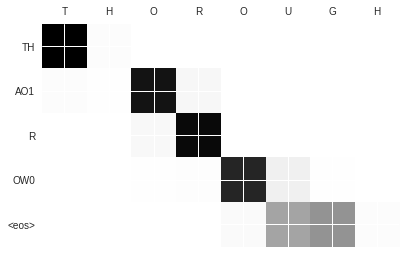

In [0]:
def show_attn(attn_model, word):
    int_word = [letter_vocab[letter] for letter in word]
    x = Variable(torch.LongTensor(int_word).view(1, -1))
    states, mask = attn_model.encode(x)
    
    x2 = Variable(torch.zeros((1, 1)).long(), volatile=True)
    x2[0, 0] = phoneme_vocab['<start>']
    hidden = Variable(torch.zeros(1, 1, hidden_size))
    result = []
    attn_matrix = []
    for i in range(200):
        y_scores, hidden, attn = attn_model.decode(x2, states, mask, hidden)
        attn_matrix.append(attn.squeeze().data.tolist())
        y_pred = torch.max(y_scores, 2)[1]
        selected = int(y_pred.data[0, 0].numpy())
        result.append(rev_phoneme_vocab[selected])
        if selected == phoneme_vocab['<eos>']:
            break
        x2[0, 0] = selected
    
    plt.matshow(attn_matrix)
    plt.xticks(range(len(word)), word)
    plt.yticks(range(len(result)), result)
    plt.show()

show_attn(attn_model, 'THOROUGH')

Pour aller plus loin
--------------------

- Apprendre un système qui regénère les mots à partir de la séquence de phonèmes. Lexique3 (http://www.lexique.org/) contient par exemple des phonétisations pour le français qui est beaucoup plus ambigu que l'anglais.
- Ce modèle est la base d'un système de traduction comme openNMT (http://opennmt.net/). On peut entraîner un petit système de traduction sur les mots et obtenir des bons résultats. Il est recommandé d'appliquer la méthode du "byte pair encoding" pour créer des symboles pour les facteurs de mots fréquents et limiter ainsi le nombre de symboles différents à prédire.
- On peut implémenter plusieurs têtes d'attention avec des parmètres différents qui agissent en parallèle et peuvent se focaliser sur des états cachés localisés à différents endroits des entrées.
- Le modèle `seq2seq` est bon pour traiter des problèmes de transduction pour lesquels il y a un alignement entre les entrées et les sorties. Un tel modèle est-il capable d'apprendre des concepts plus abstraits comme calculer le résutlat d'une expression mathématique à partir des caractères qui la constituent (par exemple $2\times(3+4) \to 14$) ?   